## Setup

**Required Libraries:** pandas, numpy, matplotlib, seaborn, nflreadpy

**Installation with UV:**
```bash
# Install UV if you don't have it
curl -LsSf https://astral.sh/uv/install.sh | sh  # macOS/Linux
# OR
powershell -c "irm https://astral.sh/uv/install.ps1 | iex"  # Windows

# Install packages
uv pip install pandas numpy matplotlib seaborn nflreadpy
```

**Data Source:** nflfastR play-by-play data (2021-2025 seasons) - automatically downloaded and cached on first run via nflreadpy

# NFL Quarterback Performance Analysis (2021-2025)

## Project Overview

I wanted to create a comprehensive statistical analysis evaluating NFL quarterback performance across several seasons using advanced metrics beyond traditional box scores. This analysis identifies elite performers, situational specialists, and pocket management styles using play-by-play data.

### Analysis Goals
1. **Rank QBs by total value creation** (passing + rushing EPA)
2. **Evaluate consistency across game situations** (down, field position, score)
3. **Identify pocket management vs offensive aggressiveness trade-offs**

### Key Metrics
- **EPA (Expected Points Added)**: Context-aware metric measuring play value relative to average outcomes in similar situations
- **CPOE (Completion % Over Expected)**: Accuracy metric adjusted for throw difficulty
- **Sack Rate & Yards/Attempt**: Pocket management and offensive efficiency indicators

**Sample Size Filter:** 300+ pass attempts (ensures statistical reliability)

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nflreadpy

# Visualization config
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['figure.dpi'] = 100

print(f"pandas: {pd.__version__} | numpy: {np.__version__} | nflreadpy: {nflreadpy.__version__}")

pandas: 2.3.3 | numpy: 2.3.5 | nflreadpy: 0.1.5


## Data Acquisition

Loading 2021-2025 NFL play-by-play data (~500k+ plays) from nflfastR via nflreadpy.

In [25]:
# Load 2021-2025 play-by-play data
seasons = range(2021, 2026)  # 2021, 2022, 2023, 2024, 2025
pbp_list = []

for season in seasons:
    print(f"Loading {season} season...")
    pbp_season = nflreadpy.load_pbp(season).to_pandas()
    pbp_list.append(pbp_season)

pbp = pd.concat(pbp_list, ignore_index=True)

print(f"\nDataset: {pbp.shape[0]:,} plays × {pbp.shape[1]} features")
print(f"Seasons: {pbp['season'].min()}-{pbp['season'].max()}")
print(f"Plays per season:\n{pbp['season'].value_counts().sort_index()}")
display(pbp.head())

Loading 2021 season...
Loading 2022 season...
Loading 2023 season...
Loading 2022 season...
Loading 2023 season...
Loading 2024 season...
Loading 2025 season...
Loading 2024 season...
Loading 2025 season...

Dataset: 226,640 plays × 372 features
Seasons: 2021-2025
Plays per season:
season
2021    49922
2022    49434
2023    49665
2024    49492
2025    28127
Name: count, dtype: int64

Dataset: 226,640 plays × 372 features
Seasons: 2021-2025
Plays per season:
season
2021    49922
2022    49434
2023    49665
2024    49492
2025    28127
Name: count, dtype: int64


,play_id,game_id,old_game_id,home_team,away_team,season_type,week,posteam,posteam_type,defteam,...,out_of_bounds,home_opening_kickoff,qb_epa,xyac_epa,xyac_mean_yardage,xyac_median_yardage,xyac_success,xyac_fd,xpass,pass_oe
0,1.0,2021_01_ARI_TEN,2021091207,TEN,ARI,REG,1,None,None,None,...,0.0,1.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,40.0,2021_01_ARI_TEN,2021091207,TEN,ARI,REG,1,TEN,home,ARI,...,0.0,1.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,55.0,2021_01_ARI_TEN,2021091207,TEN,ARI,REG,1,TEN,home,ARI,...,0.0,1.0,-1.399805,NaN,NaN,NaN,NaN,NaN,0.491433,-49.143299
3,76.0,2021_01_ARI_TEN,2021091207,TEN,ARI,REG,1,TEN,home,ARI,...,0.0,1.0,0.032412,1.165133,5.803177,4.0,0.896654,0.125098,0.697346,30.265415
4,100.0,2021_01_ARI_TEN,2021091207,TEN,ARI,REG,1,TEN,home,ARI,...,0.0,1.0,-1.532898,0.256036,4.147637,2.0,0.965009,0.965009,0.978253,2.174652


### Key Data Fields

- **Player identifiers**: `passer_player_name`, `rusher_player_name`
- **Play outcomes**: `epa`, `cpoe`, `complete_pass`, `yards_gained`, `air_yards`
- **Play classification**: `pass_attempt`, `rush_attempt`, `down`, `yardline_100`
- **Game context**: `score_differential`, `season`, `week`

## Data Processing & Feature Engineering

**Pipeline:**
1. Separate passing and rushing plays for all QBs
2. Aggregate statistics by quarterback (passing and rushing separately)
3. Merge datasets to combine dual-threat QB contributions
4. Calculate total EPA metrics (passing + rushing combined)
5. Derive efficiency metrics (completion %, sack rate, yards/attempt, TD:INT ratio)
6. Filter for sample size (≥300 pass attempts)

In [28]:
# Filter passing plays and calculate comprehensive QB statistics
passing_plays = pbp[pbp['pass_attempt'] == 1].copy()
passing_plays = passing_plays[passing_plays['passer_player_name'].notnull()]

# Calculate success (positive EPA plays)
passing_plays['success'] = (passing_plays['epa'] > 0).astype(int)

print(f"Passing plays: {len(passing_plays):,} ({len(passing_plays)/len(pbp)*100:.1f}% of total)")

# Filter rushing plays for QBs (designed runs + scrambles)
rushing_plays = pbp[(pbp['rush_attempt'] == 1) & (pbp['rusher_player_name'].notnull())].copy()
rushing_plays['success'] = (rushing_plays['epa'] > 0).astype(int)

print(f"Rushing plays: {len(rushing_plays):,} ({len(rushing_plays)/len(pbp)*100:.1f}% of total)")

# Aggregate passing statistics
pass_stats = passing_plays.groupby('passer_player_name').agg(
    pass_attempts=('pass_attempt', 'sum'),
    completions=('complete_pass', 'sum'),
    pass_tds=('pass_touchdown', 'sum'),
    interceptions=('interception', 'sum'),
    sacks=('sack', 'sum'),
    pass_epa_total=('epa', 'sum'),
    pass_epa_mean=('epa', 'mean'),
    passing_yards=('passing_yards', 'sum'),
    air_yards_total=('air_yards', 'sum'),
    cpoe_mean=('cpoe', 'mean'),
    pass_successes=('success', 'sum')
).reset_index()

# Aggregate rushing statistics
rush_stats = rushing_plays.groupby('rusher_player_name').agg(
    rush_attempts=('rush_attempt', 'sum'),
    rush_epa_total=('epa', 'sum'),
    rush_epa_mean=('epa', 'mean'),
    rushing_yards=('rushing_yards', 'sum'),
    rush_successes=('success', 'sum')
).reset_index()
rush_stats.rename(columns={'rusher_player_name': 'passer_player_name'}, inplace=True)

# Merge passing and rushing stats
qb_stats = pass_stats.merge(rush_stats, on='passer_player_name', how='left')
qb_stats.fillna({'rush_attempts': 0, 'rush_epa_total': 0, 'rush_epa_mean': 0, 
                 'rushing_yards': 0, 'rush_successes': 0}, inplace=True)

# Calculate total (passing + rushing) metrics
qb_stats['total_plays'] = qb_stats['pass_attempts'] + qb_stats['rush_attempts']
qb_stats['total_epa'] = qb_stats['pass_epa_total'] + qb_stats['rush_epa_total']
qb_stats['total_epa_per_play'] = qb_stats['total_epa'] / qb_stats['total_plays']
qb_stats['total_successes'] = qb_stats['pass_successes'] + qb_stats['rush_successes']
qb_stats['total_success_rate'] = 100 * (qb_stats['total_successes'] / qb_stats['total_plays'])

# Calculate passing-only derived metrics
qb_stats['completion_pct'] = 100 * (qb_stats['completions'] / qb_stats['pass_attempts'])
qb_stats['pass_success_rate'] = 100 * (qb_stats['pass_successes'] / qb_stats['pass_attempts'])
qb_stats['td_int_ratio'] = qb_stats['pass_tds'] / qb_stats['interceptions'].replace(0, 1)
qb_stats['yards_per_attempt'] = qb_stats['passing_yards'] / qb_stats['pass_attempts']
qb_stats['sack_rate'] = 100 * (qb_stats['sacks'] / (qb_stats['pass_attempts'] + qb_stats['sacks']))
qb_stats['td_rate'] = 100 * (qb_stats['pass_tds'] / qb_stats['pass_attempts'])
qb_stats['int_rate'] = 100 * (qb_stats['interceptions'] / qb_stats['pass_attempts'])
qb_stats['air_yards_per_attempt'] = qb_stats['air_yards_total'] / qb_stats['pass_attempts']

# Filter for statistical significance (300+ pass attempts)
MIN_ATTEMPTS = 300
qb_stats = qb_stats[qb_stats['pass_attempts'] >= MIN_ATTEMPTS].sort_values('total_epa_per_play', ascending=False)

print(f"\nQualifying QBs (≥{MIN_ATTEMPTS} pass attempts): {len(qb_stats)}")
print(f"\nTop 10 QBs by Total EPA/Play (Passing + Rushing):")
display(qb_stats[['passer_player_name', 'pass_attempts', 'rush_attempts', 'total_plays', 
                   'pass_epa_mean', 'rush_epa_mean', 'total_epa_per_play', 'cpoe_mean']].head(10))

Passing plays: 93,916 (41.4% of total)
Rushing plays: 70,137 (30.9% of total)

Qualifying QBs (≥300 pass attempts): 68

Top 10 QBs by Total EPA/Play (Passing + Rushing):
Rushing plays: 70,137 (30.9% of total)

Qualifying QBs (≥300 pass attempts): 68

Top 10 QBs by Total EPA/Play (Passing + Rushing):


,passer_player_name,pass_attempts,rush_attempts,total_plays,pass_epa_mean,rush_epa_mean,total_epa_per_play,cpoe_mean
26,B.Purdy,1424.0,156.0,1580.0,0.220983,0.146639,0.213642,2.856444
104,J.Allen,2969.0,601.0,3570.0,0.158703,0.448125,0.207426,2.650506
195,P.Mahomes,3477.0,380.0,3857.0,0.161683,0.291142,0.174438,3.196646
134,J.Love,1559.0,132.0,1691.0,0.146877,0.056417,0.139816,1.582043
111,J.Daniels,836.0,239.0,1075.0,0.095549,0.270929,0.134540,2.306798
167,L.Jackson,2086.0,613.0,2699.0,0.120249,0.180579,0.133951,2.621902
84,D.Prescott,2548.0,218.0,2766.0,0.118057,0.059124,0.113412,2.072939
127,J.Hurts,2510.0,769.0,3279.0,0.073925,0.230173,0.110569,3.577001
107,J.Burrow,2639.0,216.0,2855.0,0.108563,0.129269,0.110130,4.505314
242,T.Tagovailoa,2221.0,135.0,2356.0,0.136990,-0.408463,0.105735,2.523894


## Visualizations

Three complementary analyses reveal different dimensions of QB performance:

**1. Total EPA vs CPOE** - Identifies QBs who create value (EPA) through accurate execution (CPOE). Credits dual-threat QBs by combining passing and rushing EPA.

**2. Situational Performance Heatmap** - Shows top 15 QBs' passing EPA across game contexts. Elite QBs maintain effectiveness regardless of down, field position, or score.

**3. Sack Rate vs Yards/Attempt** - Reveals pocket management style: do QBs protect the ball and take sacks, or push downfield aggressively?

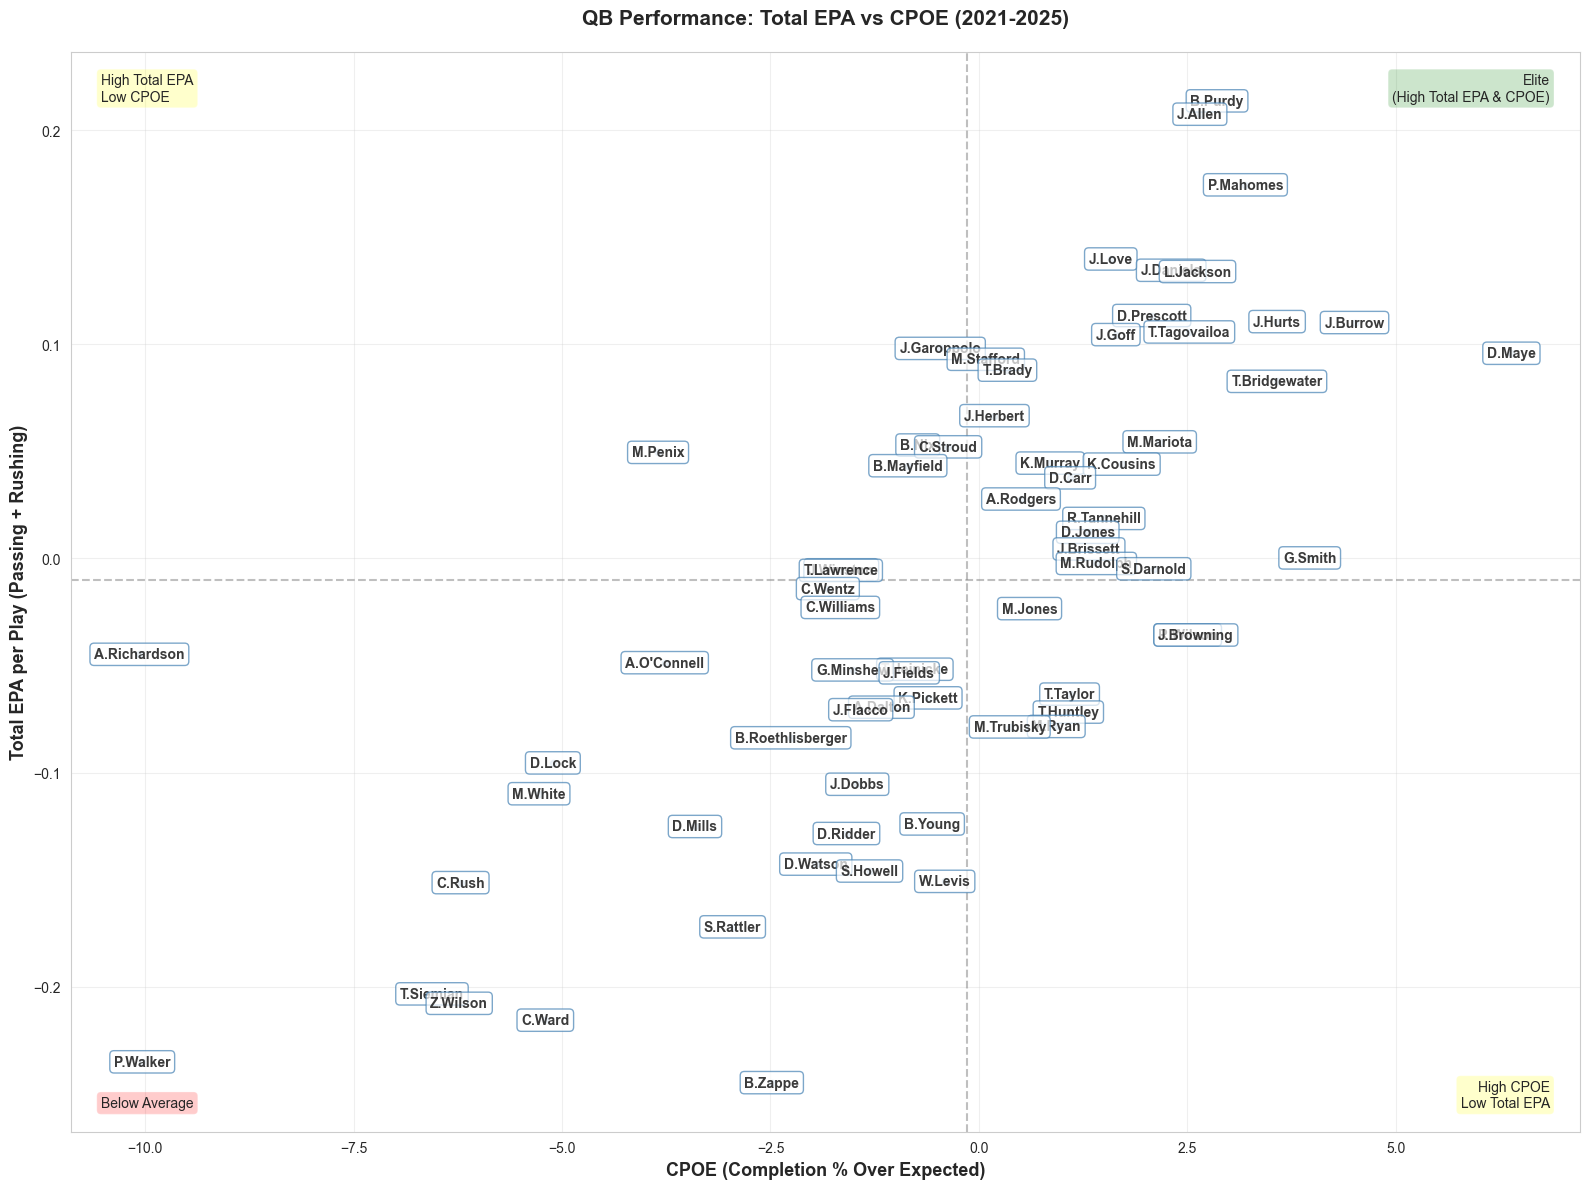


Median Total EPA/play: -0.010
Median Passing EPA/play: -0.023
Median CPOE: -0.143

Total EPA/play = (Passing EPA + Rushing EPA) / Total plays
CPOE = Completion % Over Expected (passing accuracy relative to difficulty)


In [29]:
# VISUALIZATION 1: Total EPA/Play (Pass + Rush) vs CPOE
# Y-axis = Total EPA/play (passing + rushing value), X-axis = CPOE (passing accuracy)

fig, ax = plt.subplots(figsize=(16, 12))

# Add quadrant lines
ax.axhline(y=qb_stats['total_epa_per_play'].median(), color='gray', linestyle='--', linewidth=1.5, alpha=0.5)
ax.axvline(x=qb_stats['cpoe_mean'].median(), color='gray', linestyle='--', linewidth=1.5, alpha=0.5)

# Plot small markers for reference
ax.scatter(qb_stats['cpoe_mean'], qb_stats['total_epa_per_play'], 
           s=20, color='steelblue', alpha=0.3, zorder=1)

# Label all QBs with their names
for _, qb in qb_stats.iterrows():
    ax.text(qb['cpoe_mean'], qb['total_epa_per_play'], qb['passer_player_name'],
            fontsize=10, fontweight='bold', alpha=0.9,
            ha='center', va='center',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                     edgecolor='steelblue', alpha=0.7, linewidth=1),
            zorder=2)

ax.set_xlabel('CPOE (Completion % Over Expected)', fontsize=13, fontweight='bold')
ax.set_ylabel('Total EPA per Play (Passing + Rushing)', fontsize=13, fontweight='bold')
ax.set_title('QB Performance: Total EPA vs CPOE (2021-2025)', 
             fontsize=15, fontweight='bold', pad=20)

# Quadrant labels
ax.text(0.98, 0.98, 'Elite\n(High Total EPA & CPOE)', 
        transform=ax.transAxes, fontsize=10, ha='right', va='top',
        bbox=dict(boxstyle='round', facecolor='green', alpha=0.2))
ax.text(0.02, 0.98, 'High Total EPA\nLow CPOE', 
        transform=ax.transAxes, fontsize=10, ha='left', va='top',
        bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.2))
ax.text(0.98, 0.02, 'High CPOE\nLow Total EPA', 
        transform=ax.transAxes, fontsize=10, ha='right', va='bottom',
        bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.2))
ax.text(0.02, 0.02, 'Below Average', 
        transform=ax.transAxes, fontsize=10, ha='left', va='bottom',
        bbox=dict(boxstyle='round', facecolor='red', alpha=0.2))

ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nMedian Total EPA/play: {qb_stats['total_epa_per_play'].median():.3f}")
print(f"Median Passing EPA/play: {qb_stats['pass_epa_mean'].median():.3f}")
print(f"Median CPOE: {qb_stats['cpoe_mean'].median():.3f}")
print(f"\nTotal EPA/play = (Passing EPA + Rushing EPA) / Total plays")
print(f"CPOE = Completion % Over Expected (passing accuracy relative to difficulty)")

### Metric Definitions

**EPA (Expected Points Added)**

EPA measures play value by comparing the expected points before and after a play, accounting for down, distance, field position, and score.

*Example*: On 3rd-and-2 from the opponent's 30-yard line, the offense expects ~2.5 points. A 10-yard completion for a first down moves them to the 20-yard line with ~3.5 expected points → **+1.0 EPA**.

*Why it matters*: Context-aware evaluation. A 5-yard gain on 3rd-and-4 generates more EPA than a 15-yard gain on 3rd-and-20. Explosive plays and turnovers are properly weighted.

*In this analysis*: **Total EPA** combines passing and rushing to properly credit mobile QBs (Lamar Jackson, Josh Allen, Jalen Hurts).

**CPOE (Completion % Over Expected)**

CPOE measures accuracy adjusted for throw difficulty. Statistical models predict completion probability based on throw distance, receiver separation, and defensive pressure. CPOE = actual completion % minus expected completion %.

*Why it matters*: Separates QB skill from scheme. A checkdown-heavy offense may have 70% completion rate but negative CPOE. Elite QBs consistently beat completion expectations.

**Why These Together?**
- **EPA** = outcome quality (did it help the team win?)
- **CPOE** = process quality (did the QB execute the throw well?)
- Elite QBs excel at both: accurate throws that create value

C:\Users\carme\AppData\Local\Temp\ipykernel_35852\3020226032.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  heatmap_data = passing_context.groupby(['passer_player_name', situation])['epa'].mean().unstack(fill_value=0)
C:\Users\carme\AppData\Local\Temp\ipykernel_35852\3020226032.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  heatmap_data = passing_context.groupby(['passer_player_name', situation])['epa'].mean().unstack(fill_value=0)


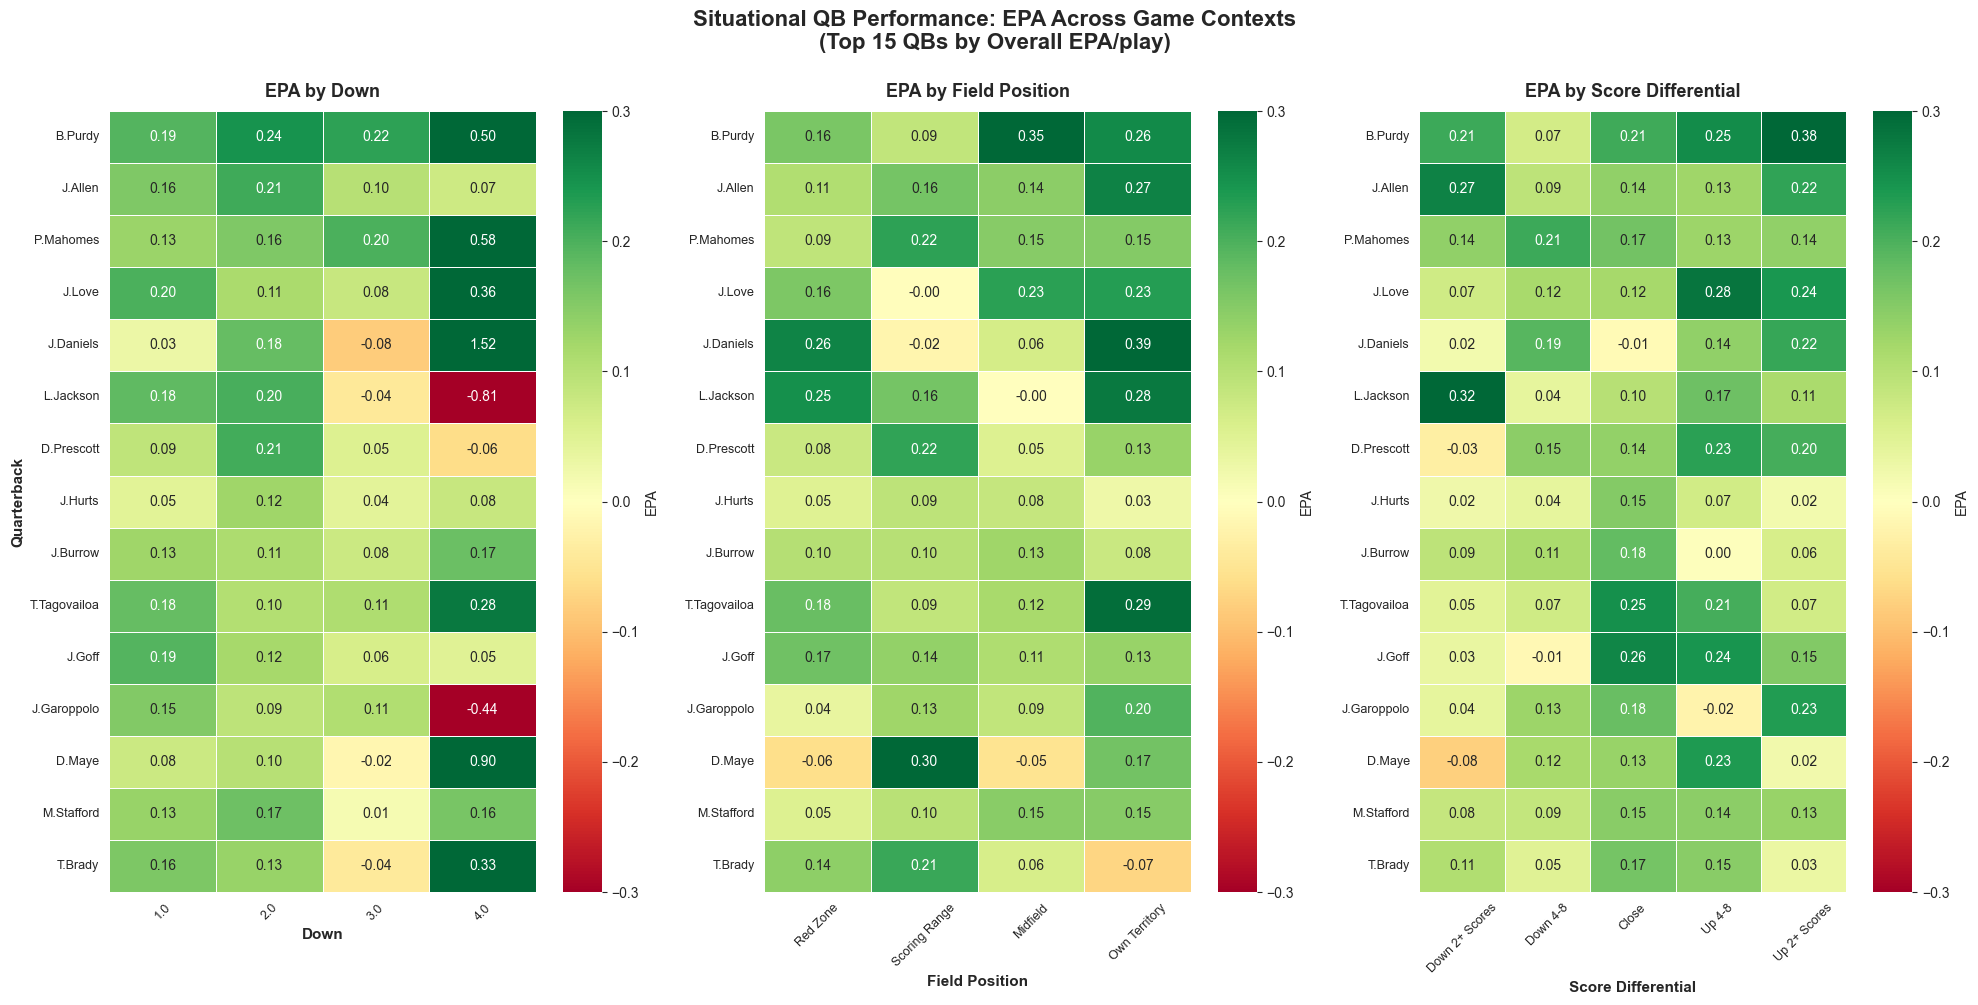


Situational Performance Insights:
  • Green = Positive EPA (effective)
  • Red = Negative EPA (ineffective)
  • Elite QBs show consistently green across all situations


In [ ]:
# VISUALIZATION 2: Situational Performance Heatmap
# EPA in different game contexts (down, field position, score differential)

# Create situational contexts
passing_plays['down'] = passing_plays['down'].astype(str)
passing_plays['field_zone'] = pd.cut(passing_plays['yardline_100'], 
                                      bins=[0, 20, 50, 75, 100],
                                      labels=['Red Zone', 'Scoring Range', 'Midfield', 'Own Territory'])
passing_plays['score_diff'] = passing_plays['score_differential']
passing_plays['score_situation'] = pd.cut(passing_plays['score_diff'],
                                           bins=[-100, -8, -3, 3, 8, 100],
                                           labels=['Down 2+ Scores', 'Down 4-8', 'Close', 'Up 4-8', 'Up 2+ Scores'])

# Select top 15 QBs for heatmap
top_qbs_heatmap = qb_stats.nlargest(15, 'total_epa_per_play')['passer_player_name'].tolist()
passing_context = passing_plays[passing_plays['passer_player_name'].isin(top_qbs_heatmap)]

# Filter out plays with missing down information
passing_context = passing_context[passing_context['down'] != 'nan']

# Calculate EPA by QB and situation
situations = ['down', 'field_zone', 'score_situation']
situation_labels = ['Down', 'Field Position', 'Score Differential']

fig, axes = plt.subplots(1, 3, figsize=(20, 10))

for idx, (situation, label) in enumerate(zip(situations, situation_labels)):
    # Calculate mean EPA by QB and situation
    heatmap_data = passing_context.groupby(['passer_player_name', situation])['epa'].mean().unstack(fill_value=0)
    
    # Reorder by overall EPA
    qb_order = [qb for qb in top_qbs_heatmap if qb in heatmap_data.index]
    heatmap_data = heatmap_data.loc[qb_order]
    
    # Create heatmap
    sns.heatmap(heatmap_data, ax=axes[idx], cmap='RdYlGn', center=0, 
                vmin=-0.3, vmax=0.3, annot=True, fmt='.2f',
                cbar_kws={'label': 'EPA'}, linewidths=0.5)
    
    axes[idx].set_title(f'EPA by {label}', fontsize=13, fontweight='bold', pad=10)
    axes[idx].set_xlabel(label, fontsize=11, fontweight='bold')
    axes[idx].set_ylabel('Quarterback' if idx == 0 else '', fontsize=11, fontweight='bold')
    axes[idx].tick_params(axis='y', labelsize=9)
    axes[idx].tick_params(axis='x', labelsize=9, rotation=45)

plt.suptitle('Situational QB Performance: EPA Across Game Contexts\n(Top 15 QBs by Overall EPA/play)', 
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print("\nSituational Performance Insights:")
print(f"  • Green = Positive EPA (effective)")
print(f"  • Red = Negative EPA (ineffective)")
print(f"  • Elite QBs show consistently green across all situations")


## Results & Interpretation

### What These Visualizations Reveal

**Visualization 1: Total EPA vs CPOE**
- Upper-right quadrant = Elite tier (high value + accurate execution)
- Upper-left = Value creators with lower accuracy (often mobile QBs)
- Lower-right = Accurate but limited value generation
- Combines passing and rushing EPA to properly evaluate dual-threat QBs

**Visualization 2: Situational Heatmap**

- Green cells = effective EPA in that context- **System QB**: High CPOE but limited EPA, struggles when script breaks down

- Red cells = struggles in specific situations- **Dual-Threat Specialist**: High total EPA (rushing boost), green on early downs

- Elite QBs show green across all contexts (consistent regardless of game state)- **Efficient Pocket Passer**: High EPA/CPOE, green in clean pockets, low sack rate

- Reveals situational specialists vs all-around performers- **Elite All-Around**: Top-right in all three charts, green heatmap

### Performance Profile Examples

**Visualization 3: Sack Rate vs Yards/Attempt**

- Upper-right = Elite (avoids sacks while pushing downfield)- Lower-left = High risk (sacks + low production)

- Upper-left = Aggressive style (takes sacks but generates yards)- Lower-right = Conservative (protects ball but limited explosiveness)

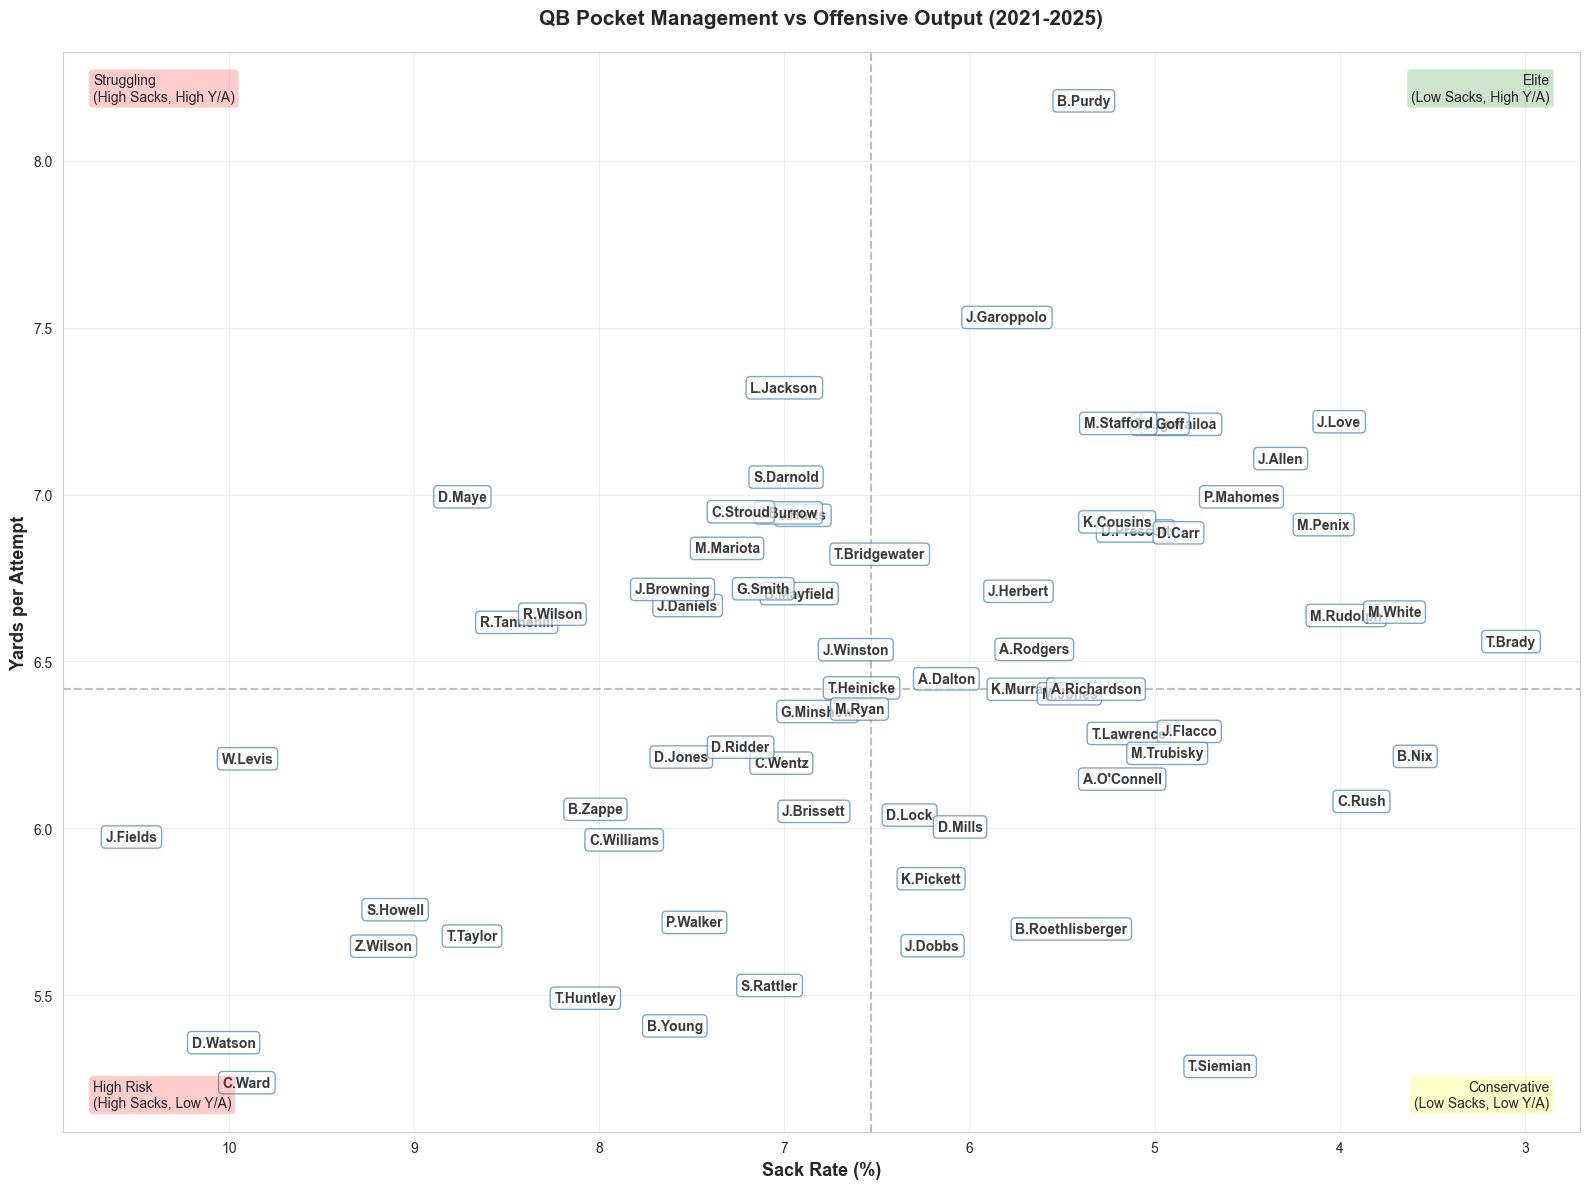


Median Sack Rate: 6.53%
Median Yards/Attempt: 6.42

Interpretation:
  • Upper-left quadrant = Elite (low sacks, high yards)
  • Upper-right quadrant = Struggling (high sacks, high yards - taking risks)
  • Lower-left quadrant = Conservative (low sacks, low yards - safe but limited)
  • Lower-right quadrant = High Risk (high sacks, low yards - worst of both)
  • Sack Rate = Sacks / (Pass Attempts + Sacks)
  • Y/A measures downfield aggressiveness and completion efficiency combined


In [37]:
# VISUALIZATION 3: Sack Rate vs Yards per Attempt
# X-axis = Sack Rate (pocket awareness), Y-axis = Yards/Attempt (aggressiveness)

fig, ax = plt.subplots(figsize=(16, 12))

# Add quadrant lines
ax.axhline(y=qb_stats['yards_per_attempt'].median(), color='gray', linestyle='--', linewidth=1.5, alpha=0.5)
ax.axvline(x=qb_stats['sack_rate'].median(), color='gray', linestyle='--', linewidth=1.5, alpha=0.5)

# Plot small markers for reference
ax.scatter(qb_stats['sack_rate'], qb_stats['yards_per_attempt'], 
           s=20, color='steelblue', alpha=0.3, zorder=1)

# Label all QBs with their names
for _, qb in qb_stats.iterrows():
    ax.text(qb['sack_rate'], qb['yards_per_attempt'], qb['passer_player_name'],
            fontsize=10, fontweight='bold', alpha=0.9,
            ha='center', va='center',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                     edgecolor='steelblue', alpha=0.7, linewidth=1),
            zorder=2)

ax.set_xlabel('Sack Rate (%)', fontsize=13, fontweight='bold')
ax.set_ylabel('Yards per Attempt', fontsize=13, fontweight='bold')
ax.set_title('QB Pocket Management vs Offensive Output (2021-2025)', 
             fontsize=15, fontweight='bold', pad=20)

# Quadrant labels
ax.text(0.98, 0.98, 'Elite\n(Low Sacks, High Y/A)', 
        transform=ax.transAxes, fontsize=10, ha='right', va='top',
        bbox=dict(boxstyle='round', facecolor='green', alpha=0.2))
ax.text(0.02, 0.98, 'Struggling\n(High Sacks, High Y/A)', 
        transform=ax.transAxes, fontsize=10, ha='left', va='top',
        bbox=dict(boxstyle='round', facecolor='red', alpha=0.2))
ax.text(0.98, 0.02, 'Conservative\n(Low Sacks, Low Y/A)', 
        transform=ax.transAxes, fontsize=10, ha='right', va='bottom',
        bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.2))
ax.text(0.02, 0.02, 'High Risk\n(High Sacks, Low Y/A)', 
        transform=ax.transAxes, fontsize=10, ha='left', va='bottom',
        bbox=dict(boxstyle='round', facecolor='red', alpha=0.2))

ax.grid(True, alpha=0.3)

# Invert X-axis so lower sack rate (better) appears on the right
ax.invert_xaxis()

plt.tight_layout()
plt.show()

print(f"\nMedian Sack Rate: {qb_stats['sack_rate'].median():.2f}%")
print(f"Median Yards/Attempt: {qb_stats['yards_per_attempt'].median():.2f}")
print(f"\nInterpretation:")
print(f"  • Upper-left quadrant = Elite (low sacks, high yards)")
print(f"  • Upper-right quadrant = Struggling (high sacks, high yards - taking risks)")
print(f"  • Lower-left quadrant = Conservative (low sacks, low yards - safe but limited)")
print(f"  • Lower-right quadrant = High Risk (high sacks, low yards - worst of both)")
print(f"  • Sack Rate = Sacks / (Pass Attempts + Sacks)")
print(f"  • Y/A measures downfield aggressiveness and completion efficiency combined")
